### variable meaning
* pred: index of video sequence 
* time: predicted time step SA: 0-2, EA: 0-4
* K: index of K-th nearest neighbor

In [34]:
import torch
import pickle
import numpy as np
import sys
sys.path.append('../')
from utils.poincare_distance import poincare_distance
import os
import imageio
from IPython.display import display, Image
from tqdm.notebook import tqdm
import PIL.Image

In [35]:
embed_path = '/proj/vondrick/didac/code/DPC/logs/log_train_earlyaction_hyper_v1_poincare_kinetics_lr4/20201023_151021/embeds/model_best_epoch31_embeds.pkl'
f = open(embed_path,"rb")
feature_dict = pickle.load(f)

In [36]:
feature_dict['pred'].shape

torch.Size([75328, 7, 256])

In [37]:
feature_dict['feature'].shape

torch.Size([75328, 1, 256])

# sample examples to be searched

In [38]:
num_embeds = len(feature_dict['vpath'])

In [39]:
np.random.seed(2020)
seq_index = np.sort(np.random.choice(range(num_embeds), replace=False, size=200))

In [40]:
pred_feature = feature_dict['pred'][seq_index]
vpath = [feature_dict['vpath'][seq_index[i]] for i in range(len(seq_index))]
idx_block = feature_dict['idx_block'][seq_index]
sample_feature = feature_dict['feature']

# score matrix

In [41]:
score_list = []
for i in range(pred_feature.shape[1]):
    score_list.append(poincare_distance(pred_feature[:, i, :], sample_feature[:, 0, :]))
score_list = torch.stack(score_list)

In [42]:
nn_indices = []
nn_values = []
for i in range(pred_feature.shape[1]):
    nn_indices.append(torch.topk(score_list[i], 10, dim=1, largest=False).indices)
    nn_values.append(torch.topk(score_list[i], 10, dim=1, largest=False).values)
nn_indices = torch.stack(nn_indices)
nn_values = torch.stack(nn_values)

In [49]:
nn_values

tensor([[[0.7236, 0.7972, 0.8011,  ..., 0.8524, 0.8562, 0.8564],
         [0.7767, 0.7935, 0.8416,  ..., 0.9077, 0.9116, 0.9268],
         [0.7610, 0.7938, 0.8035,  ..., 0.8442, 0.8483, 0.8552],
         ...,
         [1.3493, 1.3727, 1.3885,  ..., 1.4238, 1.4266, 1.4283],
         [1.0303, 1.0572, 1.0709,  ..., 1.1440, 1.1495, 1.1600],
         [0.8261, 0.8741, 0.8795,  ..., 0.9166, 0.9196, 0.9237]],

        [[0.6605, 0.7711, 0.7920,  ..., 0.8259, 0.8260, 0.8306],
         [0.7748, 0.8015, 0.8146,  ..., 0.9400, 0.9466, 0.9516],
         [0.7134, 0.8165, 0.8278,  ..., 0.8787, 0.8798, 0.8858],
         ...,
         [1.3546, 1.3931, 1.3944,  ..., 1.4230, 1.4275, 1.4288],
         [1.1228, 1.1253, 1.1262,  ..., 1.2438, 1.2451, 1.2656],
         [0.7336, 0.8380, 0.8529,  ..., 0.9161, 0.9259, 0.9317]],

        [[0.6576, 0.8045, 0.8374,  ..., 0.8681, 0.8681, 0.8727],
         [0.7962, 0.8164, 0.8374,  ..., 0.8820, 0.8989, 0.9114],
         [0.6513, 0.8213, 0.8245,  ..., 0.8552, 0.8588, 0.

In [45]:
vpath[45088].split('/')[-2].replace(' ', '-')

IndexError: list index out of range

In [48]:
nn_indices.shape

torch.Size([7, 200, 10])

# show nearest neighbors

In [34]:
def display_gif(gif_path):
    with open(gif_path,'rb') as f:
        display(Image(data=f.read(), format='png'))

In [35]:
def get_vpath(feature_dict, nn_indices, time_ind, seq_ind, K):
    '''
    Return vpath and list of K-th nearest neighbors
    '''
    sample_ind = nn_indices[time_ind][seq_ind][K]
    vpath = feature_dict['vpath'][seq_ind]
    idx_block = feature_dict['idx_block'][sample_ind]
    start = idx_block[25 + time_ind * 5] # TODO: generalize the index to arbitrary pred_step and num_seq
    end = start + 15
    return vpath, np.arange(start.item(), end.item()), sample_ind

In [45]:
def generate_gif(vpath, idx_block, sample_ind, save=True, time_ind=None, seq_ind=None, K=None):
    '''
    generate gif given vpath and idx_block, save with time, pred, K information
    '''
    if save:
        assert all(x is not None for x in [time_ind, seq_ind, K])
    images = []
    for idx in idx_block:
        im_path = os.path.join(vpath, 'image_%0.5d.jpg' % idx)
        if os.path.exists(im_path):
            images.append(PIL.Image.open(im_path))
    print(len(images))
    if save:
        NN_path = os.path.join('/'.join(embed_path.split('/')[:-1]), 'NN')
        if not os.path.exists(NN_path):
            os.mkdir(NN_path)
        gif_path = os.path.join(NN_path, 'time-%d_seq-%d_K-%d.gif' % (time_ind, seq_ind, K))
        images[0].save(gif_path, format='GIF', append_images=images[1:], save_all=True, loop=0)
        return images, gif_path
    return images

In [53]:
def save_gif(feature_dict, nn_indices, time_ind=0, seq_ind=10, K=5, show=False):
    vpath, idx_block, sample_ind = get_vpath(feature_dict, nn_indices, time_ind=time_ind, seq_ind=seq_ind, K=K)
    images, gif_path = generate_gif(vpath, idx_block, sample_ind=sample_ind, save=True, time_ind=time_ind, seq_ind=seq_ind, K=K)
    if show:
        display_gif(gif_path)

15


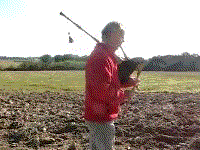

In [54]:
save_gif(feature_dict, nn_indices, time_ind=1, seq_ind=29, K=3, show=True)

# generate all original gifs

In [44]:
for i in tqdm(range(len(seq_index))):
    seq_ind = seq_index[i]
    vpath = feature_dict['vpath'][seq_ind]
    idx_block = feature_dict['idx_block'][seq_ind]
    start = idx_block[0]
    end = start + 25 # TODO: make it general to all num_seq and pred_step
    idx_block = np.arange(start.item(), end.item())
    images = []
    for idx in idx_block:
        im_path = os.path.join(vpath, 'image_%0.5d.jpg' % idx)
        if os.path.exists(im_path):
            images.append(PIL.Image.open(im_path))
        
    NN_path = os.path.join('/'.join(embed_path.split('/')[:-1]), 'NN')
    if not os.path.exists(NN_path):
        os.mkdir(NN_path)
    gif_path = os.path.join(NN_path, 'seq-%d.gif' % i)
    images[0].save(gif_path, format='GIF', append_images=images[1:], save_all=True, loop=0)

# generate all nearest neighbor gif

In [45]:
for time_ind in range(3):
    print('time step 1')
    for seq_ind in tqdm(range(len(seq_index))):
        for K in range(3):
            save_gif(feature_dict, nn_indices, time_ind=time_ind, seq_ind=seq_ind, K=K, show=False)

In [17]:
vpath[0].split('/')[-2].replace(' ', '-')

'cracking-back'

In [18]:
a = 10
b = 20

In [19]:
c = a + 10 if b > 30 else a - 10

In [20]:
c

0